<center>

## Code Appendix:
## Machine Learning Pipeline for Microdata Imputation with Deep Learning Models

</center>

Note that code in this notebook requires two different environments to run: one with Python 3.10 (for probaforms models) and another with Python 3.13 (for microimpute models). All code pertaining to QRF imputations was run in a separate document and exported onto this one for organizational purposes.

<center>

## The data

</center>

<!-- TODO: Describe the data sources:
- Survey of Consumer Finances (SCF): Federal Reserve survey, wealth data
- Current Population Survey (CPS): Census Bureau survey, demographic data
- Sampling methodology and data collection
- Why these datasets are used for imputation
-->

In [ ]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import h5py
import pickle
import os
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from sklearn.model_selection import KFold

from microimpute.models import QRF
from probaforms.models import RealNVP
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import MDNConfig

# Model saving utilities
os.makedirs('saved_models', exist_ok=True)

def save_realnvp(model, path='saved_models/realnvp_final.pkl'):
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"RealNVP saved to {path}")

def load_realnvp(path='saved_models/realnvp_final.pkl'):
    with open(path, 'rb') as f:
        return pickle.load(f)

def save_mdn(model, path='saved_models/mdn_final'):
    model.save_model(path)
    print(f"MDN saved to {path}")

def load_mdn(path='saved_models/mdn_final'):
    from pytorch_tabular import TabularModel
    return TabularModel.load_model(path)

In [2]:
def load_scf(
    years,
    columns=None,
):
    """Load Survey of Consumer Finances data for specified years and columns.

    Args:
        years: Year or list of years to load data for.
        columns: List of column names to load.

    Returns:
        DataFrame containing the requested data.

    Raises:
        ValueError: If no Stata files are found in the downloaded zip
            or invalid parameters
        RuntimeError: If there's a network error or a problem processing
            the downloaded data
    """

    all_data = []

    for year in tqdm(years):
        try:
            # Download zip file
            print(f"Downloading SCF data for year {year}")
            url = f"https://www.federalreserve.gov/econres/files/scfp{year}s.zip"
            try:
                response = requests.get(url, timeout=60)
                response.raise_for_status()  # Raise an error for bad responses
            except requests.exceptions.RequestException as e:
                print(
                    f"Network error downloading SCF data for year {year}: {str(e)}"
                )
                raise RuntimeError(
                    f"Failed to download SCF data for year {year}"
                ) from e

            # Process zip file
            try:
                print("Creating zipfile from downloaded content")
                z = zipfile.ZipFile(io.BytesIO(response.content))

                # Find the .dta file in the zip
                dta_files = [
                    f for f in z.namelist() if f.endswith(".dta")
                ]
                if not dta_files:
                    print(
                        f"No Stata files found in zip for year {year}"
                    )
                    raise ValueError(
                        f"No Stata files found in zip for year {year}"
                    )

                # Read the Stata file
                try:
                    print(f"Reading Stata file: {dta_files[0]}")
                    with z.open(dta_files[0]) as f:
                        df = pd.read_stata(
                            io.BytesIO(f.read()), columns=columns
                        )
                        print(
                            f"Read DataFrame with shape {df.shape}"
                        )

                    # Ensure 'wgt' is included
                    if (
                        columns is not None
                        and "wgt" not in df.columns
                        and "wgt" not in columns
                    ):
                        print("Re-reading with 'wgt' column added")
                        # Re-read to include weights
                        with z.open(dta_files[0]) as f:
                            cols_with_weight = list(
                                set(columns) | {"wgt"}
                            )
                            df = pd.read_stata(
                                io.BytesIO(f.read()),
                                columns=cols_with_weight,
                            )
                            print(
                                f"Re-read DataFrame with shape {df.shape}"
                            )
                except Exception as e:
                    print(
                        f"Error reading Stata file for year {year}: {str(e)}"
                    )
                    raise RuntimeError(
                        f"Failed to process Stata file for year {year}"
                    ) from e

            except zipfile.BadZipFile as e:
                print(f"Bad zip file for year {year}: {str(e)}")
                raise RuntimeError(
                    f"Downloaded zip file is corrupt for year {year}"
                ) from e

            # Add year column
            df["year"] = year
            all_data.append(df)

        except Exception as e:
            print(f"Error in _load: {str(e)}")
            raise

        # Combine all years
        print(f"Combining data from {len(all_data)} years")
        if len(all_data) > 1:
            result = pd.concat(all_data)
            return result
        else:
            print(
                f"Returning data for single year, shape: {all_data[0].shape}"
            )
            return all_data[0]


scf = load_scf([2022])

  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/yg/xdp70k_n4qj9ph1_0lm435c00000gp/T/ipykernel_17707/1701353024.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["year"] = year
  0%|          | 0/1 [00:00<?, ?it/s]

Creating zipfile from downloaded content
Reading Stata file: rscfp2022.dta
Read DataFrame with shape (22975, 357)
Combining data from 1 years
Returning data for single year, shape: (22975, 358)


In [3]:
def flatten_h5_file(file_path):
    """Load all datasets from H5 file into a flat dictionary, ignoring table structure"""
    with h5py.File(file_path, 'r') as f:
        data = {}
        
        # Iterate through tables (groups)
        for table_name in f.keys():
            table = f[table_name]
            
            if isinstance(table, h5py.Group):
                # Iterate through variables in this table
                for var_name in table.keys():
                    if isinstance(table[var_name], h5py.Dataset):
                        # Add to flat dictionary with just the variable name
                        data[var_name] = table[var_name][:]
                        
            elif isinstance(table, h5py.Dataset):
                # In case there are top-level datasets
                data[table_name] = table[:]
        
        return data


def load_cps(year, columns=None):
    """Load Current Population Survey data for specified year and columns.

    Args:
        year: Year to load data for.
        columns: List of column names to load. If None, loads all columns.

    Returns:
        Dictionary mapping column names to numpy arrays.

    Raises:
        ValueError: If invalid parameters provided
        RuntimeError: If there's a network error or a problem processing
            the downloaded data
    """
    
    try:
        # Download HDF5 file from HuggingFace
        print(f"Downloading CPS data for year {year}")
        url = f"https://huggingface.co/policyengine/policyengine-us-data/resolve/main/cps_{year}.h5"
        
        try:
            response = requests.get(url, timeout=120)
            response.raise_for_status()  # Raise an error for bad responses
        except requests.exceptions.RequestException as e:
            print(
                f"Network error downloading CPS data for year {year}: {str(e)}"
            )
            raise RuntimeError(
                f"Failed to download CPS data for year {year}"
            ) from e
        
        # Save to temporary file and process HDF5 file using h5py
        try:
            print("Reading HDF5 file from downloaded content")
            
            # Save to temporary file
            import tempfile
            import os
            with tempfile.NamedTemporaryFile(delete=False, suffix='.h5') as tmp_file:
                tmp_file.write(response.content)
                tmp_path = tmp_file.name
            
            # Load using the flatten_h5_file function
            data_dict = flatten_h5_file(tmp_path)
            
            # Clean up temporary file
            os.unlink(tmp_path)
            
            print(f"Loaded {len(data_dict)} columns from CPS data")
            
            # Filter columns if specified
            if columns is not None:
                # Ensure 'weight' is included
                cols_to_keep = set(columns) | {"weight"}
                # Only keep columns that exist in the data
                filtered_dict = {k: v for k, v in data_dict.items() if k in cols_to_keep}
                print(f"Filtered to {len(filtered_dict)} columns")
                return filtered_dict
            else:
                return data_dict
                
        except Exception as e:
            print(
                f"Error reading HDF5 file for year {year}: {str(e)}"
            )
            raise RuntimeError(
                f"Failed to process HDF5 file for year {year}"
            ) from e
        
    except Exception as e:
        print(f"Error in load_cps: {str(e)}")
        raise


cps = load_cps(2023)

Reading HDF5 file from downloaded content
Loaded 128 columns from CPS data


<center>

## Data preprocessing

</center>

In [4]:
cps_race_mapping = {
    1: 1,  # White only -> WHITE
    2: 2,  # Black only -> BLACK/AFRICAN-AMERICAN
    3: 5,  # American Indian, Alaskan Native only -> OTHER
    4: 4,  # Asian only -> ASIAN
    5: 5,  # Hawaiian/Pacific Islander only -> OTHER
    6: 5,  # White-Black -> OTHER
    7: 5,  # White-AI -> OTHER
    8: 5,  # White-Asian -> OTHER
    9: 3,  # White-HP -> HISPANIC
    10: 5,  # Black-AI -> OTHER
    11: 5,  # Black-Asian -> OTHER
    12: 3,  # Black-HP -> HISPANIC
    13: 5,  # AI-Asian -> OTHER
    14: 5,  # AI-HP -> OTHER
    15: 3,  # Asian-HP -> HISPANIC
    16: 5,  # White-Black-AI -> OTHER
    17: 5,  # White-Black-Asian -> OTHER
    18: 5,  # White-Black-HP -> OTHER
    19: 5,  # White-AI-Asian -> OTHER
    20: 5,  # White-AI-HP -> OTHER
    21: 5,  # White-Asian-HP -> OTHER
    22: 5,  # Black-AI-Asian -> OTHER
    23: 5,  # White-Black-AI-Asian -> OTHER
    24: 5,  # White-AI-Asian-HP -> OTHER
    25: 5,  # Other 3 race comb. -> OTHER
    26: 5,  # Other 4 or 5 race comb. -> OTHER
}

# Apply the mapping to recode the race values
cps["race"] = np.vectorize(cps_race_mapping.get)(cps["cps_race"])
cps["farm_self_employment_income"] = (
    cps["self_employment_income"] + cps["farm_income"]
)
cps["interest_dividend_income"] = (
    cps["taxable_interest_income"]
    + cps["tax_exempt_interest_income"]
    + cps["qualified_dividend_income"]
    + cps["non_qualified_dividend_income"]
)
cps["pension_income"] = (
    cps["tax_exempt_private_pension_income"]
    + cps["taxable_private_pension_income"]
    + cps["social_security_retirement"]
)

mask_head = cps["is_household_head"]
income_df = pd.DataFrame(
    {
        "household_id": cps["person_household_id"],
        "employment_income": cps["employment_income"],
        "farm_self_employment_income": cps["farm_self_employment_income"],
        "interest_dividend_income": cps["interest_dividend_income"],
        "pension_income": cps["pension_income"],
    }
)
household_sums = income_df.groupby("household_id").sum().reset_index()
heads = pd.DataFrame(
    {
        "household_id": cps["person_household_id"][mask_head],
        "is_female": cps["is_female"][mask_head],
        "age": cps["age"][mask_head],
        "race": cps["race"][mask_head],
        "own_children_in_household": cps["own_children_in_household"][
            mask_head
        ],
    }
)
hh_level = heads.merge(household_sums, on="household_id", how="left")

for name, series in cps.items():
    if isinstance(series, pd.Series) and len(series) == len(hh_level):
        if name not in hh_level.columns:
            hh_level[name] = series.values


cols = (
    ["household_id"]
    + [
        "farm_self_employment_income",
        "interest_dividend_income",
        "pension_income",
        "employment_income",
    ]
    + ["own_children_in_household", "is_female", "age", "race"]
)
cps_data = hh_level[cols]
cps_data["wgt"] = cps["household_weight"]
cps_data["is_female"] = cps_data["is_female"].astype(int)

household_weights = ["wgt"]

# sim = Microsimulation(dataset="/Users/movil1/Desktop/PYTHONJOBS/PolicyEngine/microimpute/CPS 2023.h5")
# net_disposable_income = sim.calculate("household_net_income")

# cps_data["household_net_income"] = net_disposable_income

/var/folders/yg/xdp70k_n4qj9ph1_0lm435c00000gp/T/ipykernel_17707/2080590043.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_data["wgt"] = cps["household_weight"]
/var/folders/yg/xdp70k_n4qj9ph1_0lm435c00000gp/T/ipykernel_17707/2080590043.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_data["is_female"] = cps_data["is_female"].astype(int)


In [5]:
# Create mapping from desired variable names to SCF column names
scf_variable_mapping = {
    "hhsex": "is_female",  # sex (is female yes/no) (hhsex)
    "age": "age",  # age of respondent (age)
    "race": "race",  # race of respondent (race)
    "kids": "own_children_in_household",  # number of children in household (kids)
    "wageinc": "employment_income",  # income from wages and salaries (wageinc)
    "bussefarminc": "farm_self_employment_income",  # income from business, self-employment or farm (bussefarminc)
    "intdivinc": "interest_dividend_income",  # income from interest and dividends (intdivinc)
    "ssretinc": "pension_income",  # income from social security and retirement accounts (ssretinc)
}

original_columns = list(scf_variable_mapping.keys()) + ["networth", "wgt"]
scf_df = pd.DataFrame({col: scf[col] for col in original_columns})
scf_data = scf_df.rename(columns=scf_variable_mapping)

# Convert hhsex to is_female (hhsex: 1=male, 2=female -> is_female: 0=male, 1=female)
scf_data["is_female"] = (scf_data["is_female"] == 2).astype(int)

predictors = [
    "is_female",
    "age",
    #"own_children_in_household",
    "race",
    "employment_income",
    "interest_dividend_income",
    "pension_income",
]

imputed_variables = ["networth"]

weights = ["wgt"]

scf_data = scf_data[predictors + imputed_variables + weights]
cps_data = cps_data[predictors + weights]

<center>

## Initial exploratory analysis

</center>

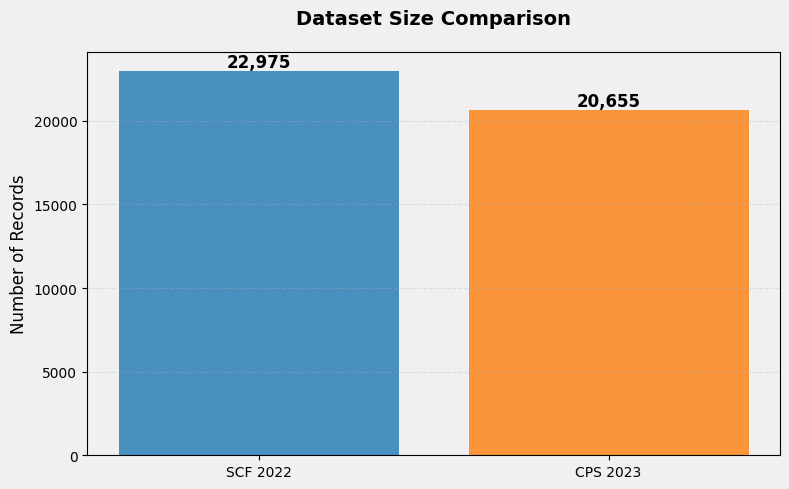

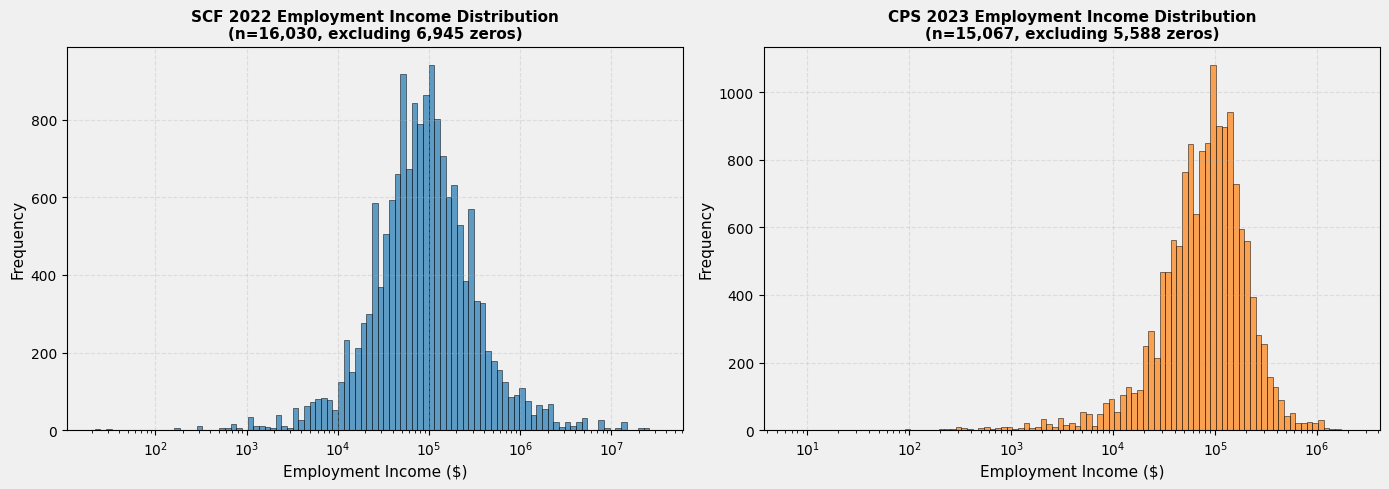

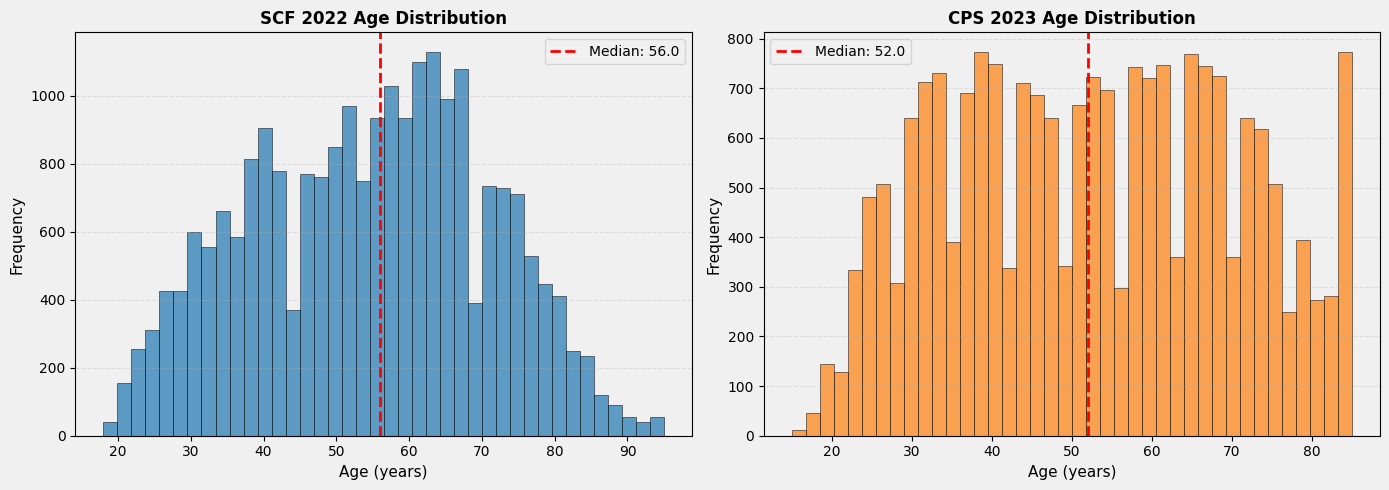

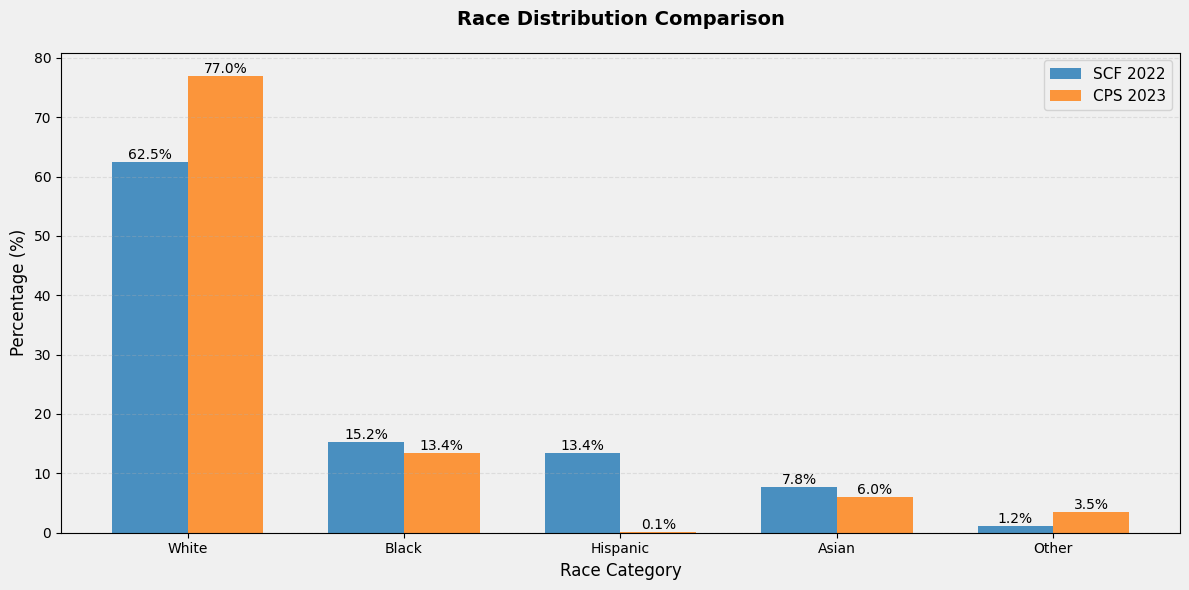

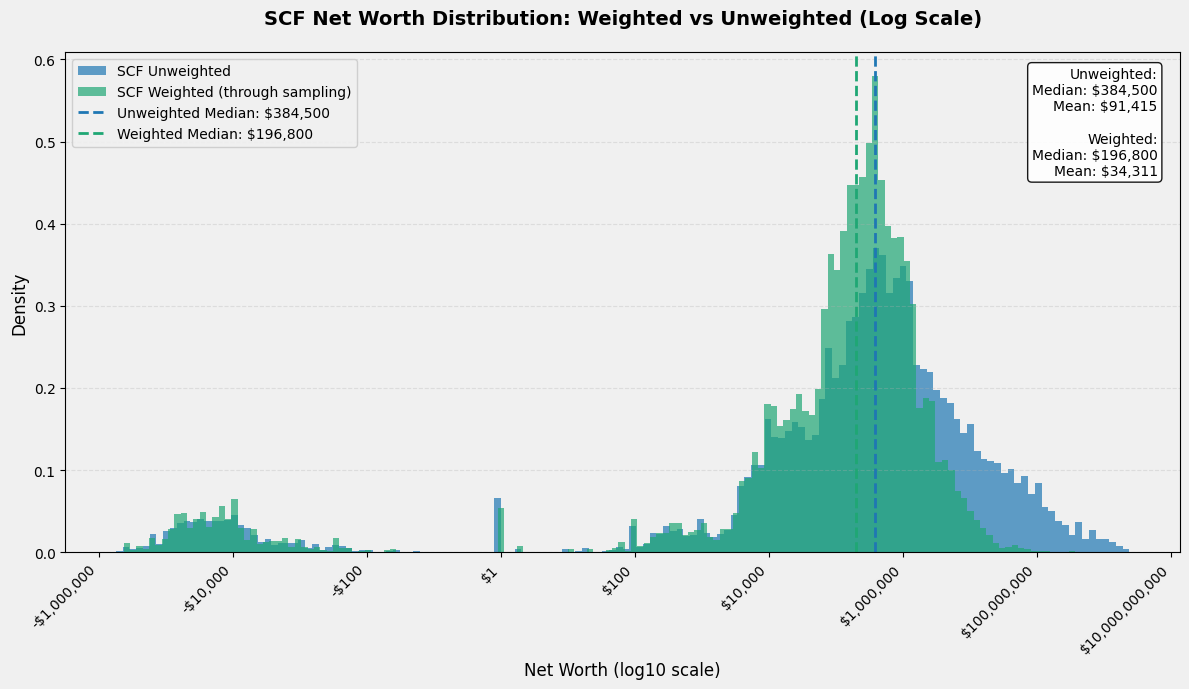


Summary Statistics:
SCF 2022: 22,975 records
CPS 2023: 20,655 records

Median Age - SCF: 56.0, CPS: 52.0
Median Employment Income - SCF: $45,398, CPS: $54,600

Net Worth - Unweighted Median: $384,500
Net Worth - Weighted Median: $196,800


In [6]:
# Exploratory analysis

# Set up matplotlib style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = '#F0F0F0'
plt.rcParams['axes.facecolor'] = '#F0F0F0'

# 1. Compare total number of records
fig, ax = plt.subplots(figsize=(8, 5))
datasets = ['SCF 2022', 'CPS 2023']
record_counts = [len(scf_data), len(cps_data)]
bars = ax.bar(datasets, record_counts, color=['#1f77b4', '#ff7f0e'], alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Records', fontsize=12)
ax.set_title('Dataset Size Comparison', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Compare employment income distributions (with log scale)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out zeros and negative values for log scale
scf_employment_positive = scf_data[scf_data['employment_income'] > 0]['employment_income']
cps_employment_positive = cps_data[cps_data['employment_income'] > 0]['employment_income']

# Create logarithmically-spaced bins
scf_bins = np.logspace(np.log10(scf_employment_positive.min()),
                       np.log10(scf_employment_positive.max()),
                       100)
cps_bins = np.logspace(np.log10(cps_employment_positive.min()),
                       np.log10(cps_employment_positive.max()),
                       100)

# SCF employment income
axes[0].hist(scf_employment_positive, bins=scf_bins, color='#1f77b4',
             alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Employment Income ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'SCF 2022 Employment Income Distribution\n(n={len(scf_employment_positive):,}, excluding {len(scf_data) - len(scf_employment_positive):,} zeros)',
                  fontsize=11, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(axis='both', alpha=0.3, linestyle='--')

# CPS employment income
axes[1].hist(cps_employment_positive, bins=cps_bins, color='#ff7f0e',
             alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Employment Income ($)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'CPS 2023 Employment Income Distribution\n(n={len(cps_employment_positive):,}, excluding {len(cps_data) - len(cps_employment_positive):,} zeros)',
                  fontsize=11, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(axis='both', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 3. Compare age distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SCF age
axes[0].hist(scf_data['age'], bins=40, color='#1f77b4', 
             alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Age (years)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('SCF 2022 Age Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].axvline(scf_data['age'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {scf_data["age"].median():.1f}')
axes[0].legend()

# CPS age
axes[1].hist(cps_data['age'], bins=40, color='#ff7f0e', 
             alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('CPS 2023 Age Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].axvline(cps_data['age'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {cps_data["age"].median():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# 4. Compare race proportions
race_labels = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Other'}

# Calculate proportions
scf_race_counts = scf_data['race'].value_counts()
scf_race_props = (scf_race_counts / len(scf_data) * 100).sort_index()

cps_race_counts = cps_data['race'].value_counts()
cps_race_props = (cps_race_counts / len(cps_data) * 100).sort_index()

# Create comparison bar plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(race_labels))
width = 0.35

scf_values = [scf_race_props.get(i, 0) for i in range(1, 6)]
cps_values = [cps_race_props.get(i, 0) for i in range(1, 6)]

bars1 = ax.bar(x - width/2, scf_values, width, label='SCF 2022', 
               color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, cps_values, width, label='CPS 2023', 
               color='#ff7f0e', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Race Category', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Race Distribution Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([race_labels[i] for i in range(1, 6)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 5. Weighted vs Unweighted SCF Net Worth Distribution
# Create weighted sample
weights_col = scf_data["wgt"].values
weights_normalized = weights_col / weights_col.sum()
scf_data_weighted = scf_data.sample(
    n=len(scf_data),
    replace=True,
    weights=weights_normalized,
    random_state=42
).reset_index(drop=True)

# Safe log transformation function
def safe_log10(x):
    """Apply log10 to absolute values, preserving sign."""
    sign = np.sign(x)
    log_x = np.log10(np.maximum(np.abs(x), 1e-10))
    return sign * log_x

# Apply safe log transformation
scf_log = safe_log10(scf_data["networth"])
scf_weighted_log = safe_log10(scf_data_weighted["networth"])

# Create the figure
fig, ax = plt.subplots(figsize=(12, 7))

# Plot histograms
n1, bins1, patches1 = ax.hist(scf_log, bins=150, alpha=0.7, label='SCF Unweighted',
                                color='#1f77b4', density=True)
n2, bins2, patches2 = ax.hist(scf_weighted_log, bins=150, alpha=0.7, 
                                label='SCF Weighted (through sampling)',
                                color='#1fa774', density=True)

# Calculate statistics
unweighted_median = np.median(scf_log)
weighted_median = np.median(scf_weighted_log)
unweighted_mean = np.mean(scf_log)
weighted_mean = np.mean(scf_weighted_log)

# Add median lines
ax.axvline(unweighted_median, color='#1f77b4', linestyle='--', linewidth=2,
           label=f'Unweighted Median: ${10**unweighted_median:,.0f}')
ax.axvline(weighted_median, color='#1fa774', linestyle='--', linewidth=2,
           label=f'Weighted Median: ${10**weighted_median:,.0f}')

# Customize x-axis with dollar formatting
tick_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10]
tick_labels = []
for x_val in tick_values:
    if x_val >= 0:
        tick_labels.append(f'${10**x_val:,.0f}')
    else:
        tick_labels.append(f'-${10**abs(x_val):,.0f}')

ax.set_xticks(tick_values)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

ax.set_xlabel('Net Worth (log10 scale)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('SCF Net Worth Distribution: Weighted vs Unweighted (Log Scale)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add text box with statistics
stats_text = (
    f'Unweighted:\n'
    f'Median: ${10**unweighted_median:,.0f}\n'
    f'Mean: ${10**unweighted_mean:,.0f}\n\n'
    f'Weighted:\n'
    f'Median: ${10**weighted_median:,.0f}\n'
    f'Mean: ${10**weighted_mean:,.0f}'
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1)
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

print("\nSummary Statistics:")
print(f"SCF 2022: {len(scf_data):,} records")
print(f"CPS 2023: {len(cps_data):,} records")
print(f"\nMedian Age - SCF: {scf_data['age'].median():.1f}, CPS: {cps_data['age'].median():.1f}")
print(f"Median Employment Income - SCF: ${scf_data['employment_income'].median():,.0f}, CPS: ${cps_data['employment_income'].median():,.0f}")
print(f"\nNet Worth - Unweighted Median: ${10**unweighted_median:,.0f}")
print(f"Net Worth - Weighted Median: ${10**weighted_median:,.0f}")

In [7]:
scf_weights = scf_data["wgt"]
cps_weights = cps_data["wgt"]

# Apply weighted sampling for SCF
weights_normalized = scf_weights / scf_weights.sum()
scf_data["networth"] = scf_data["networth"].sample(
                n=len(scf_data["networth"]),
                replace=True,
                weights=weights_normalized,
                random_state=42,
            ).reset_index(drop=True)

# Apply arcsinh transformation
scf_data["transformed_networth"] = np.arcsinh(scf_data["networth"].copy())
imputed_variables = ["transformed_networth"]

<center>

## Model selection

</center>

<!-- TODO: Add mathematical foundations for each model:

### RealNVP (Normalizing Flow)
- Change of variables formula
- Affine coupling layers
- Log-likelihood objective

### MDN (Mixture Density Network)
- Gaussian mixture model output
- Network architecture
- NLL loss function

### TabSyn (Diffusion + VAE)
- VAE encoder/decoder
- Diffusion forward/reverse process
- Denoising score matching
-->

In [13]:
class VariableTypeDetector:
    """Utility class for detecting and categorizing variable types."""

    @staticmethod
    def is_boolean_variable(series: pd.Series) -> bool:
        """Check if a series represents boolean data."""
        if pd.api.types.is_bool_dtype(series):
            return True

        unique_vals = set(series.dropna().unique())
        if pd.api.types.is_integer_dtype(series) and unique_vals <= {0, 1}:
            return True
        if pd.api.types.is_float_dtype(series) and unique_vals <= {0.0, 1.0}:
            return True

        return False

    @staticmethod
    def is_categorical_variable(series: pd.Series) -> bool:
        """Check if a series represents categorical string/object data."""
        return pd.api.types.is_string_dtype(
            series
        ) or pd.api.types.is_object_dtype(series)

    @staticmethod
    def is_numeric_categorical_variable(
        series: pd.Series, max_unique: int = 10
    ) -> bool:
        """Check if a numeric series should be treated as categorical."""
        if not pd.api.types.is_numeric_dtype(series):
            return False

        if series.nunique() >= max_unique:
            return False

        # Check for equal spacing between values
        unique_values = np.sort(series.dropna().unique())
        if len(unique_values) < 2:
            return True

        differences = np.diff(unique_values)
        return np.allclose(differences, differences[0], rtol=1e-9)

    @staticmethod
    def categorize_variable(
        series,
        col_name,
        force_numeric = False,
    ):
        """
        Categorize a variable and return its type and categories if applicable.

        Args:
            series: The data series to categorize
            col_name: Name of the column
            force_numeric: If True, treat the variable as numeric even if it
                would normally be detected as numeric_categorical

        Returns:
            Tuple of (variable_type, categories)
            variable_type: 'bool', 'categorical', 'numeric_categorical', or 'numeric'
            categories: List of unique values for categorical types, None for numeric
        """
        if VariableTypeDetector.is_boolean_variable(series):
            return "bool", None

        if VariableTypeDetector.is_categorical_variable(series):
            return "categorical", series.unique().tolist()

        # Check if it would normally be numeric_categorical
        if (
            not force_numeric
            and VariableTypeDetector.is_numeric_categorical_variable(series)
        ):
            categories = [float(i) for i in series.unique().tolist()]
            print(
                f"Treating numeric variable '{col_name}' as categorical due to low unique count and equal spacing"
            )
            return "numeric_categorical", categories

        # If force_numeric is True or it's not numeric_categorical, treat as numeric
        if (
            force_numeric
            and VariableTypeDetector.is_numeric_categorical_variable(series)
        ):
            print(
                f"Variable '{col_name}' forced to be treated as numeric (override numeric_categorical detection)"
            )

        return "numeric", None


class DummyVariableProcessor:
    """Handles conversion of categorical predictors to dummy variables."""

    def __init__(self):
        self.dummy_mapping = {}  # Maps original column to dummy columns
        self.imputed_var_dummy_mapping = (
            {}
        )  # Pre-computed dummy info for imputed vars

    def preprocess_predictors(
        self,
        data: pd.DataFrame,
        predictors,
        imputed_variables,
        not_numeric_categorical = None,
    ):
        """
        Process predictor variables and pre-compute dummy encodings.

        For predictors: converts categoricals to dummies and adds to dataframe.
        For imputed_variables: pre-computes dummy info but keeps original form.

        Args:
            data: DataFrame containing the data
            predictors: List of predictor column names
            imputed_variables: List of variables to impute
            not_numeric_categorical: Optional list of variable names that should
                be treated as numeric even if they would normally be detected as
                numeric_categorical.

        Returns:
            Tuple of (processed_data, updated_predictors)
        """
        # Start with a copy containing all needed columns
        all_columns = list(set(predictors + imputed_variables))
        data = data[all_columns].copy()
        detector = VariableTypeDetector()
        not_numeric_categorical = not_numeric_categorical or []

        # Identify categorical predictors (not imputed targets)
        categorical_predictors = []
        for col in predictors:
            if col not in data.columns:
                continue
            var_type, categories = detector.categorize_variable(
                data[col],
                col,
                force_numeric=(col in not_numeric_categorical),
            )
            if var_type in ["categorical", "numeric_categorical"]:
                categorical_predictors.append(col)
                print(
                    f"Will create dummy variables for predictor '{col}' ({var_type})"
                )

        # Pre-compute dummy info for categorical imputed variables
        for col in imputed_variables:
            if col not in data.columns:
                continue
            var_type, categories = detector.categorize_variable(
                data[col],
                col,
                force_numeric=(col in not_numeric_categorical),
            )
            if var_type in ["categorical", "numeric_categorical"]:
                # Create dummy columns to determine structure
                dummy_df = pd.get_dummies(
                    data[[col]],
                    columns=[col],
                    dtype="float64",
                    drop_first=True,
                )
                dummy_cols = [
                    c for c in dummy_df.columns if c.startswith(f"{col}_")
                ]

                # Store pre-computed dummy info
                self.imputed_var_dummy_mapping[col] = {
                    "dummy_cols": dummy_cols,
                    "var_type": var_type,
                    "categories": categories,
                }
                print(
                    f"Pre-computed {len(dummy_cols)} dummy columns for imputed variable '{col}' ({var_type})"
                )
            elif var_type == "bool":
                # Track boolean imputed variables
                self.imputed_var_dummy_mapping[col] = {
                    "dummy_cols": None,
                    "var_type": "bool",
                    "categories": None,
                }

        # Process categorical predictors (add to dataframe)
        updated_predictors = predictors.copy()

        if categorical_predictors:
            # Create dummy variables for categorical predictors only
            dummy_df = pd.get_dummies(
                data[categorical_predictors],
                columns=categorical_predictors,
                dtype="float64",
                drop_first=True,
            )

            # Track mapping for each original column
            for orig_col in categorical_predictors:
                dummy_cols = [
                    col
                    for col in dummy_df.columns
                    if col.startswith(f"{orig_col}_")
                ]
                self.dummy_mapping[orig_col] = dummy_cols

                # Update predictor list
                updated_predictors.remove(orig_col)
                updated_predictors.extend(dummy_cols)

                print(
                    f"Created {len(dummy_cols)} dummy variables for '{orig_col}'"
                )

            # Drop original categorical columns and add dummies
            data = data.drop(columns=categorical_predictors)
            data = pd.concat([data, dummy_df], axis=1)

        # Convert boolean predictors to float (but keep as single column)
        for col in predictors:
            if col in data.columns:
                var_type, _ = detector.categorize_variable(
                    data[col], col
                )
                if var_type == "bool":
                    data[col] = data[col].astype("float64")
                    print(
                        f"Converted boolean predictor '{col}' to float64"
                    )

        return data, updated_predictors

    def sequential_imputed_predictor_encoding(
        self, data: pd.DataFrame, variable: str
    ) -> pd.DataFrame:
        """
        Encode a freshly imputed variable so it can become a predictor.

        For categorical imputed variables: adds pre-computed dummy columns.
        For boolean imputed variables: converts to float64.
        For numeric variables: no change needed.

        Args:
            data: DataFrame containing the imputed variable in original form
            variable: Name of the imputed variable to encode

        Returns:
            DataFrame with encoded variable (original column kept)
        """
        data = data.copy()

        if variable not in self.imputed_var_dummy_mapping:
            # Numeric variable - no encoding needed
            return data

        var_info = self.imputed_var_dummy_mapping[variable]

        if var_info["var_type"] in ["categorical", "numeric_categorical"]:
            # Add pre-computed dummy columns
            dummy_cols = var_info["dummy_cols"]

            # Create dummies from current data
            dummy_df = pd.get_dummies(
                data[[variable]],
                columns=[variable],
                dtype="float64",
                drop_first=True,
            )

            # Ensure we have all expected dummy columns
            for dummy_col in dummy_cols:
                if dummy_col not in dummy_df.columns:
                    dummy_df[dummy_col] = 0.0

            # Keep only pre-computed dummy columns
            dummy_df = dummy_df[dummy_cols]

            # Add dummy columns to dataframe (keep original too)
            data = pd.concat([data, dummy_df], axis=1)

            print(
                f"Added {len(dummy_cols)} dummy columns for sequential predictor '{variable}'"
            )

        elif var_info["var_type"] == "bool":
            # Convert boolean to float (in place)
            if variable in data.columns:
                data[variable] = data[variable].astype("float64")
                print(
                    f"Converted boolean sequential predictor '{variable}' to float64"
                )

        return data

    def get_sequential_predictor_columns(
        self, variables,
    ):
        """
        Get correct column names for sequential predictors.

        For categorical imputed variables: returns dummy column names.
        For other variables: returns original column name.

        Args:
            variables: List of variable names

        Returns:
            List of column names to use as predictors
        """
        predictor_cols = []

        for var in variables:
            if var in self.imputed_var_dummy_mapping:
                var_info = self.imputed_var_dummy_mapping[var]
                if var_info["var_type"] in [
                    "categorical",
                    "numeric_categorical",
                ]:
                    # Use dummy columns
                    predictor_cols.extend(var_info["dummy_cols"])
                else:
                    # Boolean or numeric - use original column
                    predictor_cols.append(var)
            else:
                # Not in mapping - use original column
                predictor_cols.append(var)

        return predictor_cols

    def apply_dummy_encoding_to_test(
        self,
        data,
        predictors,
    ):
        """Apply same dummy encoding to test data based on training mapping."""
        detector = VariableTypeDetector()
        data = data.copy()
        updated_predictors = predictors.copy()

        # Apply dummy encoding based on stored mapping
        for orig_col, dummy_cols in self.dummy_mapping.items():
            if orig_col in predictors and orig_col in data.columns:
                # Create dummies for this column
                dummy_df = pd.get_dummies(
                    data[[orig_col]],
                    columns=[orig_col],
                    dtype="float64",
                    drop_first=False,  # Don't drop first, we'll handle missing manually
                )

                # Ensure we have the exact dummy columns from training
                for dummy_col in dummy_cols:
                    if dummy_col not in dummy_df.columns:
                        dummy_df[dummy_col] = 0.0  # Missing category gets 0

                # Keep only the dummy columns from training
                dummy_df = dummy_df[dummy_cols]

                # Update data
                data = data.drop(columns=[orig_col])
                data = pd.concat([data, dummy_df], axis=1)

                # Update predictor list
                updated_predictors.remove(orig_col)
                updated_predictors.extend(dummy_cols)

        # Convert boolean predictors to float
        for col in predictors:
            if col in data.columns:
                var_type, _ = detector.categorize_variable(
                    data[col], col
                )
                if var_type == "bool":
                    data[col] = data[col].astype("float64")

        return data, updated_predictors

def preprocess_categorical_boolean_vars(data, predictors, imputed_variables):
    """Encode categorical and boolean variables in the dataset as numeric.
    
    This function uses microimpute's type detection and dummy variable processing
    to convert categorical and boolean predictors to numeric dummy variables.
    
    Args:
        data: DataFrame containing the data to preprocess
        predictors: List of predictor column names to process
        
    Returns:
        Tuple of (processed_data, updated_predictors) where:
        - processed_data: DataFrame with categorical/boolean vars converted to dummies
        - updated_predictors: List of new column names after dummy encoding
    """
    processor = DummyVariableProcessor()
    
    # Process predictors: convert categorical/boolean to dummy variables
    # Keep imputed variables empty since we're only processing predictors
    processed_data, updated_predictors = processor.preprocess_predictors(
        data=data,
        predictors=predictors,
        imputed_variables=imputed_variables,
        not_numeric_categorical=None  # Use default detection
    )
    
    return processed_data, updated_predictors

net_worth = scf_data[imputed_variables].values

scf_data_encoded, new_predictors = preprocess_categorical_boolean_vars(scf_data, predictors, imputed_variables)
cps_data_encoded, _ = preprocess_categorical_boolean_vars(cps_data, predictors, [])

scf_predictors = scf_data_encoded[new_predictors].values
cps_predictors = cps_data_encoded[new_predictors].values

Treating numeric variable 'race' as categorical due to low unique count and equal spacing
Will create dummy variables for predictor 'race' (numeric_categorical)
Created 4 dummy variables for 'race'
Converted boolean predictor 'is_female' to float64
Treating numeric variable 'race' as categorical due to low unique count and equal spacing
Will create dummy variables for predictor 'race' (numeric_categorical)
Created 4 dummy variables for 'race'
Converted boolean predictor 'is_female' to float64


In [ ]:
def compare_donor_receiver_dists(donor_net_worth, receiver_net_worth):
    """Compare donor and receiver net worth distributions with safe log axis.
    """
    scf_weights_normalized = scf_weights / scf_weights.sum()
    cps_weights_normalized = cps_weights / cps_weights.sum()

    donor_data = pd.DataFrame({"networth": donor_net_worth, "wgt": scf_weights_normalized})
    receiver_data = pd.DataFrame({"networth": receiver_net_worth, "wgt": cps_weights_normalized})

    donor_data = donor_data.sample(
        n=len(donor_data),
        replace=True,
        weights=scf_weights_normalized,
        random_state=405,
    ).reset_index(drop=True)
    receiver_data = receiver_data.sample(
        n=len(receiver_data),
        replace=True,
        weights=cps_weights_normalized,
        random_state=405,
    ).reset_index(drop=True)

    scf_log = safe_log10(donor_data["networth"])
    scf_weighted_log = safe_log10(receiver_data["networth"])

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot histograms
    n1, bins1, patches1 = ax.hist(scf_log, bins=150, alpha=0.7, label='SCF donor',
                                    color='#1f77b4', density=True)
    n2, bins2, patches2 = ax.hist(scf_weighted_log, bins=150, alpha=0.7, 
                                    label='CPS receiver imputed',
                                    color='#ff7f0e', density=True)

    # Calculate statistics
    unweighted_median = np.median(scf_log)
    weighted_median = np.median(scf_weighted_log)
    unweighted_mean = np.mean(scf_log)
    weighted_mean = np.mean(scf_weighted_log)

    # Add median lines
    ax.axvline(unweighted_median, color='#1f77b4', linestyle='--', linewidth=2,
            label=f'SCF Donor Median: ${10**unweighted_median:,.0f}')
    ax.axvline(weighted_median, color='#ff7f0e', linestyle='--', linewidth=2,
            label=f'CPS Receiver Imputed Median: ${10**weighted_median:,.0f}')
    # Customize x-axis with dollar formatting
    tick_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10]
    tick_labels = []
    for x_val in tick_values:
        if x_val >= 0:
            tick_labels.append(f'${10**x_val:,.0f}')
        else:
            tick_labels.append(f'-${10**abs(x_val):,.0f}')

    ax.set_xticks(tick_values)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    ax.set_xlabel('Net Worth (log10 scale)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Net Worth Distribution: SCF vs CPS Imputed (Log Scale)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add text box with statistics
    stats_text = (
        f'SCF Donor:\n'
        f'Median: ${10**unweighted_median:,.0f}\n'
        f'Mean: ${10**unweighted_mean:,.0f}\n\n'
        f'CPS Receiver Imputed:\n'
        f'Median: ${10**weighted_median:,.0f}\n'
        f'Mean: ${10**weighted_mean:,.0f}'
    )
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1)
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)

    plt.tight_layout()
    plt.show()

#### Quantile Random Forest

In [ ]:
model = QRF()
print("Fitting QRF model...")
fitted_model = model.fit(
    X_train=scf_data,
    predictors=predictors,
    imputed_variables=imputed_variables,
)
print("Imputing onto the CPS...")
qrf_imputations = fitted_model.predict(X_test=cps_data)
qrf_net_worth_imputed = np.sinh(qrf_imputations["transformed_networth"].values)

Fitting QRF model...
Imputing onto the CPS...


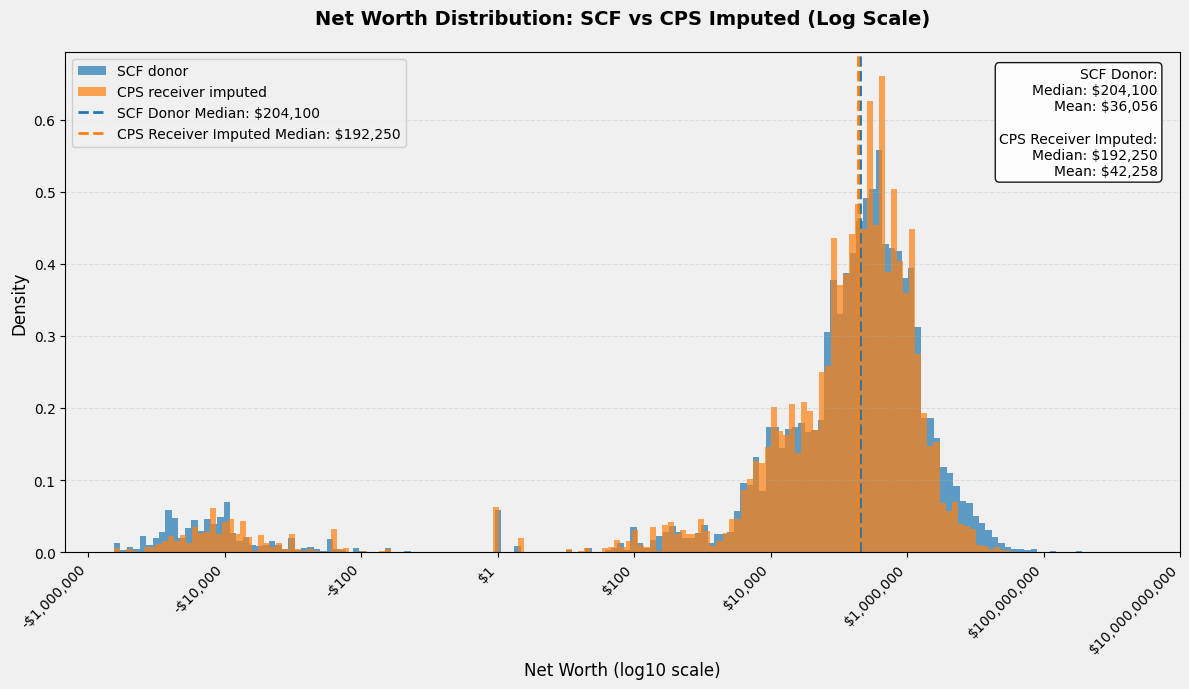

In [ ]:
compare_donor_receiver_dists(np.sinh(scf_data_encoded["transformed_networth"]), qrf_net_worth_imputed)

In [ ]:
pd.DataFrame(qrf_net_worth_imputed).to_csv('qrf_imputed_networth.csv', index=False)

#### RealNVP

In [ ]:
# Fit normalizing flow model on full SCF data
realnvp_model = RealNVP(lr=0.01, n_epochs=500)
print("Fitting RealNVP model...")
realnvp_model.fit(net_worth, scf_predictors)

# Impute onto CPS
print("Imputing onto the CPS...")
realnvp_net_worth_imputed = realnvp_model.sample(cps_predictors)
realnvp_net_worth_imputed = np.sinh(realnvp_net_worth_imputed)

# Save model
save_realnvp(realnvp_model)

Fitting RealNVP model...
Imputing onto the CPS...
RealNVP saved to saved_models/realnvp_final.pkl


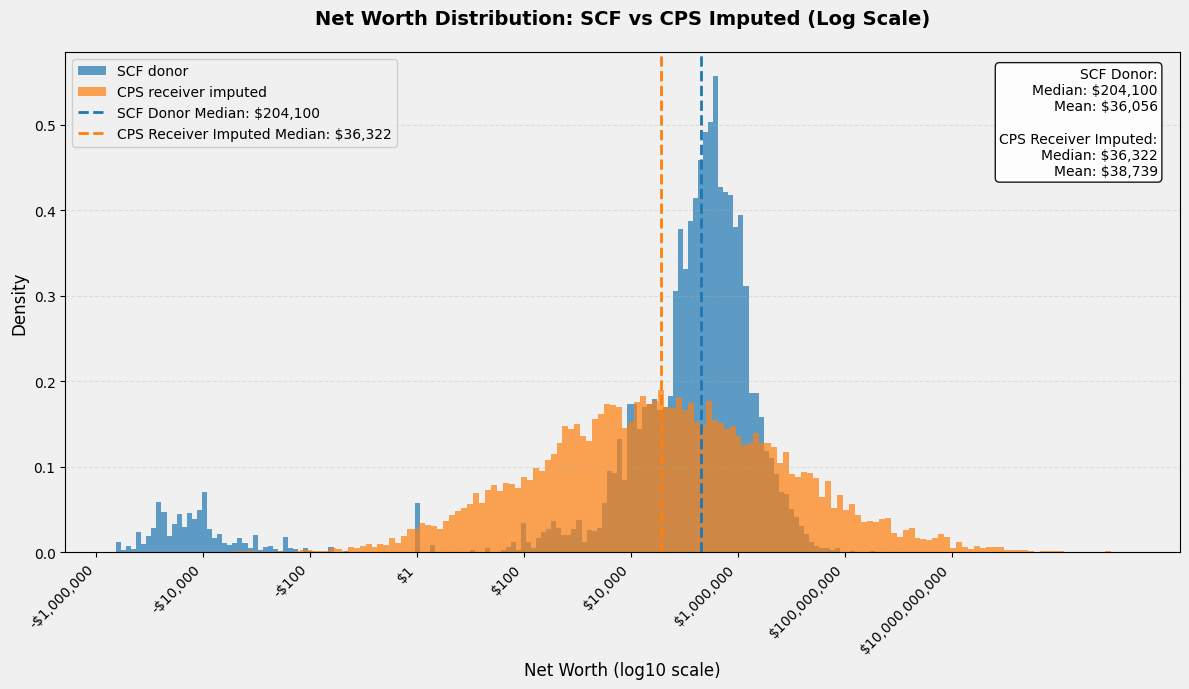

In [51]:
compare_donor_receiver_dists(scf_data["networth"], realnvp_net_worth_imputed.flatten())

In [48]:
pd.DataFrame(realnvp_net_worth_imputed).to_csv('realnvp_imputed_networth.csv', index=False)

#### MDN

In [ ]:
data_config = DataConfig(
    target=["transformed_networth"],
    continuous_cols=["age", "employment_income", "interest_dividend_income", "pension_income"],
    categorical_cols=["is_female", "race_2", "race_3", "race_4", "race_5"],
)

model_config = MDNConfig(
    task="regression",
    head_config={"num_gaussian": 5},
    backbone_config_class="CategoryEmbeddingModelConfig",
    backbone_config_params={"task": "backbone", "layers": "128-64-32", "activation": "ReLU"},
    learning_rate=1e-3,
)

trainer_config = TrainerConfig(
    max_epochs=100,
    batch_size=256,
    progress_bar="simple",
    load_best=False,
)

mdn_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=OptimizerConfig(),
    trainer_config=trainer_config,
)

print("Fitting MDN model...")
mdn_model.fit(train=scf_data_encoded)

print("Imputing onto the CPS...")
# Put model in eval mode
mdn_model.model.eval()

# Create a dataloader for the CPS data
test_loader = mdn_model.datamodule.prepare_inference_dataloader(cps_data_encoded)

# Sample from the mixture distribution
samples_list = []
with torch.no_grad():
    for batch in test_loader:
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(mdn_model.model.device)

        # Draw 1 sample per observation from the learned mixture
        samples = mdn_model.model.sample(batch, n_samples=1)
        samples_list.append(samples.squeeze(-1).cpu().numpy())

# Concatenate all batches
mdn_sampled_transformed = np.concatenate(samples_list)
mdn_net_worth_sampled = np.sinh(mdn_sampled_transformed)

# Save model
save_mdn(mdn_model)

2025-11-30 01:11:30,946 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


Fitting MDN model...


2025-11-30 01:11:31,041 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-11-30 01:11:31,068 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

2025-11-30 01:11:31,123 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: MDNModel

2025-11-30 01:11:31,145 - {pytorch_tabular.config.config:927} - WARNING - `head` is not a valid parameter for      
backbone task. Making `head=None`

2025-11-30 01:11:31,181 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-11-30 01:11:31,243 - {pytorch_tabular.tabular_model:678} - INFO - Training Started


  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 12.3 K | train
1 | _embedding_layer | Embedding1dLayer          | 38     | train
2 | _head            | MixtureDensityHead        | 490    | train
3 | loss             | MSELoss                   | 0      | train
-----------------------------------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-11-30 01:26:34,662 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Imputing onto the CPS...


2025-11-30 01:26:35,734 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

MDN saved to saved_models/mdn_final


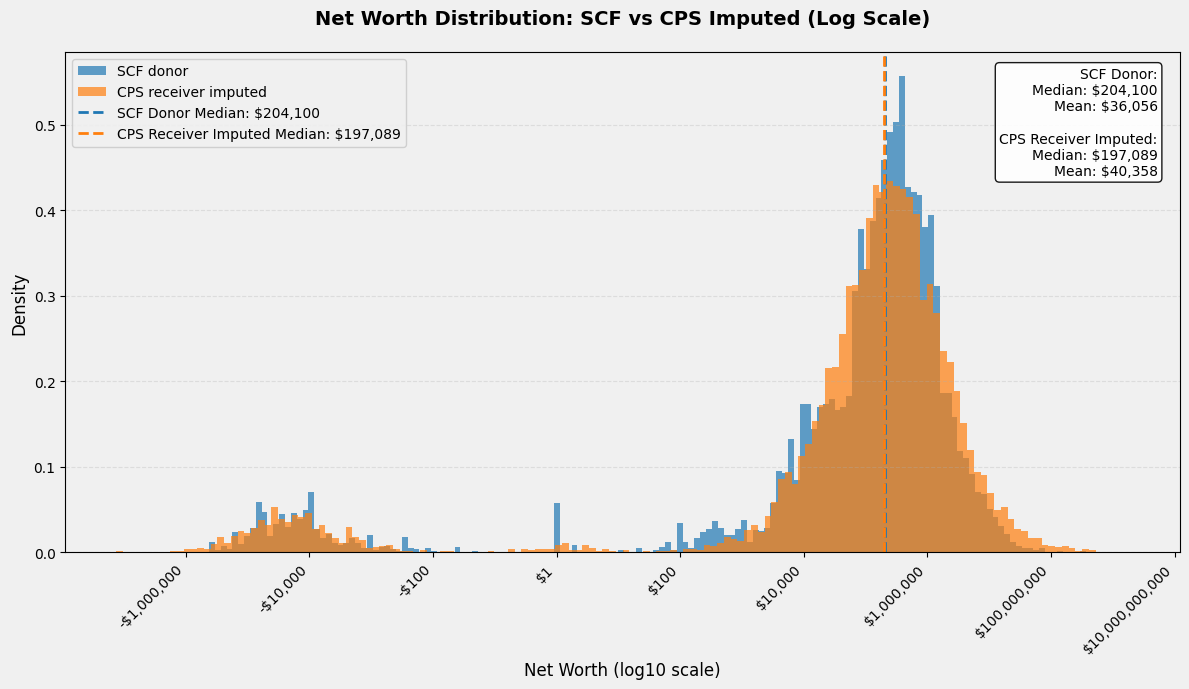

In [66]:
compare_donor_receiver_dists(scf_data["networth"], mdn_net_worth_sampled)

In [68]:
pd.DataFrame(mdn_net_worth_sampled).to_csv('mdn_imputed_networth.csv', index=False)

#### TabSyn

In [21]:
import sys
sys.path.append('tabsyn')
from tabsyn.tabsyn_wrapper import TabSynPipeline

# Suppress the pkg_resources deprecation warning
import warnings
warnings.filterwarnings('ignore', message='.*pkg_resources is deprecated.*')

# Initialize pipeline
pipeline = TabSynPipeline(
    working_dir='tabsyn',
    python_path='venv3.10/bin/python3',
    use_gpu=True,
    verbose=False,
)

results = pipeline.full_pipeline(
    scf_data=scf_data,
    cps_data=cps_data,
    predictors=predictors,
    target_variable='transformed_networth',
    weights='wgt',
    numerical_cols=['employment_income', 'interest_dividend_income', 'pension_income', 'age'],
    categorical_cols=['is_female', 'race'],
    vae_epochs=2000,
    diffusion_epochs=10000,
    num_trials=30,
    force_retrain=True,
)

Fitting preprocessor on donor data with shape: (22975, 8)
Fitted numerical transformer on 4 columns
Fitted categorical encoders on 2 columns
Fitted target transformer on 1 columns
Saved donor weights for weighted statistics computation
Preprocessor saved to data/scf_2022_preprocessor.pkl
Preprocessing complete:
  Donor (scf_2022): 22975 samples
  Receiver (cps_2023): 20655 samples
  Preprocessor saved to: data/scf_2022_preprocessor.pkl
Preprocessor loaded from data/scf_2022_preprocessor.pkl
Starting full dataset imputation:
  Donor: scf_2022
  Receiver: cps_2023
  Model: scf_2022
  Device: cpu
  Random init for target: True

Using hyperparameters from TabSyn paper:
  VAE layers: 2
  Diffusion hidden dim: 1024
  Sampling steps: 50
Preprocessor loaded from data/scf_2022_preprocessor.pkl
Loaded preprocessor from data/scf_2022_preprocessor.pkl
Processing 20655 samples from receiver dataset
self.category_embeddings.weight.shape=torch.Size([7, 4])
self.category_embeddings.weight.shape=torch.

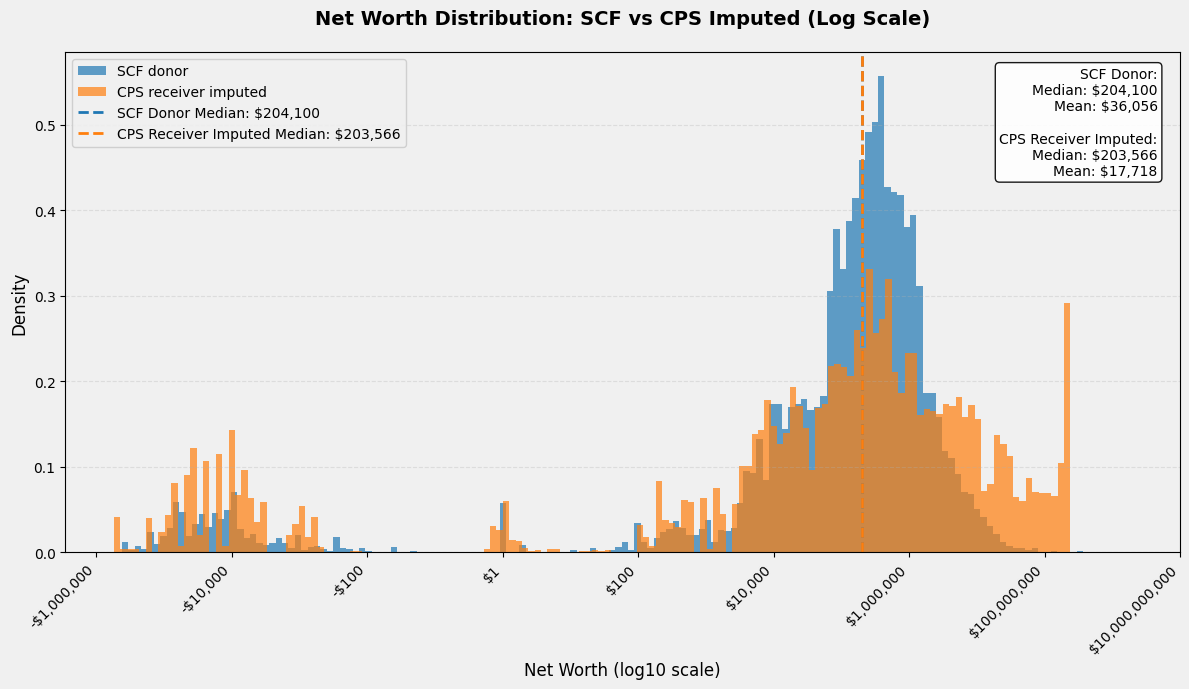

In [22]:
# Extract the imputed values from the results dictionary
tabsyn_networth = results['imputed_values']

# Compare with SCF donor distribution
compare_donor_receiver_dists(
    scf_data["networth"],
    tabsyn_networth
)

In [45]:
pd.DataFrame(tabsyn_networth).to_csv('tabsyn_imputed_networth.csv', index=False)

<center>

## Model training with cross-validation

</center>

In [36]:
# Metrics functions
def quantile_loss(q, y_true, y_pred):
    """Quantile loss from microimpute."""
    e = y_true - y_pred
    return np.mean(np.maximum(q * e, (q - 1) * e))

def compute_cv_metrics(y_true, y_pred, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    """Compute quantile losses for CV."""
    return {f'q{int(q*100)}': quantile_loss(q, y_true, y_pred) for q in quantiles}

def aggregate_cv_results(fold_results):
    """Aggregate fold results into mean/std."""
    results = {}
    for q_name in fold_results[0].keys():
        values = [f[q_name] for f in fold_results]
        results[q_name] = {'mean': np.mean(values), 'std': np.std(values)}
    return results

In [ ]:
# Cross-validation framework for QRF imputation model

def run_cv_qrf(X, predictors, imputed_variables, n_folds=3):
    """Run k-fold CV for QRF."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"QRF Fold {fold+1}/{n_folds}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx] 
        
        # QRF: fit() - donor data, and list of predictors / imputed variables
        model = QRF()
        fitted_model = model.fit(X_train, predictors=predictors, imputed_variables=imputed_variables)
        
        # Sample predictions
        y_pred = fitted_model.predict(X_val.drop(["transformed_networth"], axis=1))
        
        fold_metrics = compute_cv_metrics(X_val, y_pred)
        fold_results.append(fold_metrics)
        print(f"  Fold {fold+1} q50 loss: {fold_metrics['q50']:.4f}")
    
    return aggregate_cv_results(fold_results)

print("CV framework function defined: run_cv_qrf")

In [ ]:
# Cross-validation framework for deep learning imputation models
import sys
sys.path.append('tabsyn')
from tabsyn.tabsyn_wrapper import TabSynPipeline

def run_cv_realnvp(X, y, n_folds=3, lr=0.01, n_epochs=500):
    """Run k-fold CV for RealNVP."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"RealNVP Fold {fold+1}/{n_folds}")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # RealNVP: fit(y, X) - target first, then conditions
        model = RealNVP(lr=lr, n_epochs=n_epochs)
        model.fit(y_train.reshape(-1, 1), X_train)
        
        # Sample predictions
        y_pred = model.sample(X_val).flatten()
        
        fold_metrics = compute_cv_metrics(y_val, y_pred)
        fold_results.append(fold_metrics)
        print(f"  Fold {fold+1} q50 loss: {fold_metrics['q50']:.4f}")
    
    return aggregate_cv_results(fold_results)

def run_cv_mdn(X_df, y, continuous_cols, categorical_cols, n_folds=3, max_epochs=100):
    """Run k-fold CV for MDN."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_df)):
        print(f"MDN Fold {fold+1}/{n_folds}")
        train_df = X_df.iloc[train_idx].copy()
        train_df['target'] = y[train_idx]
        val_df = X_df.iloc[val_idx].copy()
        
        data_config = DataConfig(
            target=['target'],
            continuous_cols=continuous_cols,
            categorical_cols=categorical_cols
        )
        model_config = MDNConfig(
            task="regression",
            head_config={"num_gaussian": 5},
            backbone_config_class="CategoryEmbeddingModelConfig",
            backbone_config_params={"task": "backbone", "layers": "128-64-32"}
        )
        # load_best=False avoids PyTorch 2.6 weights_only serialization issue
        trainer_config = TrainerConfig(max_epochs=max_epochs, batch_size=256, 
                                       progress_bar="simple", load_best=False)
        
        model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=OptimizerConfig(),
            trainer_config=trainer_config,
        )
        model.fit(train=train_df, validation=None)
        
        # Predict
        model.model.eval()
        test_loader = model.datamodule.prepare_inference_dataloader(val_df)

        samples_list = []
        with torch.no_grad():
            for batch in test_loader:
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch[k] = v.to(model.model.device)

        samples = model.model.sample(batch, n_samples=1)
        samples_list.append(samples.squeeze(-1).cpu().numpy())
        y_pred = np.concatenate(samples_list)
        y_val = y[val_idx]
        
        fold_metrics = compute_cv_metrics(y_val, y_pred)
        fold_results.append(fold_metrics)
        print(f"  Fold {fold+1} q50 loss: {fold_metrics['q50']:.4f}")
    
    return aggregate_cv_results(fold_results)

def run_cv_tabsyn(X_df, y, numerical_cols, categorical_cols, n_folds=3, 
                  vae_epochs=1000, diffusion_epochs=2000, num_trials=1,
                  force_retrain=False):
    """Run k-fold CV for TabSyn (note: very slow due to diffusion training).

    We use fold-specific donor_name to keep models separate between folds.
    Set force_retrain=False to reuse existing trained models.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_df)):
        print(f"TabSyn Fold {fold+1}/{n_folds}")
        X_train = X_df.iloc[train_idx]
        X_val = X_df.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Use fold-specific donor_name to keep models separate between folds
        pipeline = TabSynPipeline(working_dir='tabsyn')
        pipeline.fit(X_train, y_train, 
                    numerical_cols=numerical_cols, 
                    categorical_cols=categorical_cols,
                    donor_name=f'cv_donor_fold{fold}',  # Fold-specific model storage
                    vae_epochs=vae_epochs, 
                    diffusion_epochs=diffusion_epochs,
                    force_retrain=force_retrain)  # Reuse models if available
        
        y_pred = pipeline.predict(X_val, num_trials=num_trials)
        
        fold_metrics = compute_cv_metrics(y_val, y_pred)
        fold_results.append(fold_metrics)
        print(f"  Fold {fold+1} q50 loss: {fold_metrics['q50']:.4f}")
    
    return aggregate_cv_results(fold_results)

print("CV framework functions defined: run_cv_realnvp, run_cv_mdn, run_cv_tabsyn")

CV framework functions defined: run_cv_realnvp, run_cv_mdn, run_cv_tabsyn


In [ ]:
# Version 1: One-hot encoded for RealNVP and MDN
race_dummies = pd.get_dummies(scf_data['race'], prefix='race', drop_first=True)
scf_encoded = pd.concat([scf_data, race_dummies], axis=1)

numerical_cols = ['age', 'employment_income', 'interest_dividend_income', 'pension_income']
categorical_cols_encoded = ['is_female'] + list(race_dummies.columns)  # One-hot encoded
predictors_encoded = numerical_cols + categorical_cols_encoded

X_df_encoded = scf_encoded[predictors_encoded].copy()
X_array_encoded = X_df_encoded.values
y = scf_encoded['transformed_networth'].values

print(f"Encoded data for RealNVP/MDN: {X_df_encoded.shape[0]} samples, {X_df_encoded.shape[1]} features")
print(f"  Numerical: {numerical_cols}")
print(f"  Categorical (one-hot): {categorical_cols_encoded}")

# Version 2: Original categorical for TabSyn  
categorical_cols_original = ['is_female', 'race']  # Original form
predictors_original = numerical_cols + categorical_cols_original

X_df_original = scf_data[predictors_original].copy()

print(f"\nOriginal data for TabSyn: {X_df_original.shape[0]} samples, {X_df_original.shape[1]} features")
print(f"  Numerical: {numerical_cols}")
print(f"  Categorical (original): {categorical_cols_original}")

Encoded data for RealNVP/MDN: 22975 samples, 9 features
  Numerical: ['age', 'employment_income', 'interest_dividend_income', 'pension_income']
  Categorical (one-hot): ['is_female', 'race_2', 'race_3', 'race_4', 'race_5']

Original data for TabSyn: 22975 samples, 6 features
  Numerical: ['age', 'employment_income', 'interest_dividend_income', 'pension_income']
  Categorical (original): ['is_female', 'race']


In [ ]:
# Run QRF CV (uses one-hot encoded data)
print("Running QRF 3-Fold Cross-Validation")
qrf_cv = run_cv_qrf(scf_data, predictors, imputed_variables, n_folds=3)
pd.DataFrame(qrf_cv).to_csv('qrf_cv_results.csv', index=True)

CV framework function defined: run_cv_qrf
Running QRF 3-Fold Cross-Validation
QRF Fold 1/3
  Fold 1 q50 loss: 2.5139
QRF Fold 2/3
  Fold 2 q50 loss: 2.5269
QRF Fold 3/3
  Fold 3 q50 loss: 2.5003


In [ ]:
# Run RealNVP CV (uses one-hot encoded data)
print("Running RealNVP 3-Fold Cross-Validation")
realnvp_cv = run_cv_realnvp(X_array_encoded, y, n_folds=3, lr=0.01, n_epochs=500)

# Run MDN CV (uses one-hot encoded data)
print("Running MDN 3-Fold Cross-Validation")
mdn_cv = run_cv_mdn(X_df_encoded, y, continuous_cols=numerical_cols, 
                            categorical_cols=categorical_cols_encoded, n_folds=3, max_epochs=100)

# Run TabSyn CV (uses original categorical data)
print("Running TabSyn 3-Fold Cross-Validation")
tabsyn_cv = run_cv_tabsyn(X_df_original, y, numerical_cols=numerical_cols,
                                   categorical_cols=categorical_cols_original, n_folds=3,
                                   vae_epochs=2000, diffusion_epochs=10000,
                                   force_retrain=True)

Epoch 1555/10001: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, Loss=0.22] 


Early stopping
Time:  5510.687499046326
Diffusion model training complete
Preprocessing data...
SCF shape: (15317, 8)
CPS shape: (7658, 8)
Predictors: ['age', 'employment_income', 'interest_dividend_income', 'pension_income', 'is_female', 'race']
Target: transformed_networth
Task type: regression
Numerical columns: ['age', 'employment_income', 'interest_dividend_income', 'pension_income']
Categorical columns: ['is_female', 'race']
Fitting preprocessor on donor data with shape: (15317, 8)
Fitted numerical transformer on 4 columns
Fitted categorical encoders on 2 columns
Fitted target transformer on 1 columns
Saved donor weights for weighted statistics computation
Preprocessor saved to data/cv_donor_fold2_preprocessor.pkl
Preprocessing complete:
  Donor (cv_donor_fold2): 15317 samples
  Receiver (cv_receiver): 7658 samples
  Preprocessor saved to: data/cv_donor_fold2_preprocessor.pkl
Preprocessor loaded from data/cv_donor_fold2_preprocessor.pkl
Saved to: data/cv_donor_fold2 and data/cv_r

Processing batches: 100%|██████████| 4/4 [07:29<00:00, 112.32s/it]

No NaNs in numerical features, skipping
  Saved trial 0 to impute/cv_receiver/0.csv

Averaging results across all trials...
Averaged results saved to impute/cv_receiver/averaged_imputation.csv
Averaged result shape: (7658, 5)
  Fold 3 q50 loss: 6.1548


<center>

## Performance evaluation of net worth imputation

</center>

In [ ]:
# Compute distributional accuracy metrics (Wasserstein distance & KS test)

scf_networth = scf_data["networth"].values
scf_w = scf_data["wgt"].values
cps_w = cps_data["wgt"].values

# Wasserstein distances (weighted)
qrf_wasserstein = wasserstein_distance(scf_networth, qrf_net_worth_imputed, scf_w, cps_w)
realnvp_wasserstein = wasserstein_distance(scf_networth, realnvp_net_worth_imputed.flatten(), scf_w, cps_w)
mdn_wasserstein = wasserstein_distance(scf_networth, mdn_net_worth_sampled, scf_w, cps_w)
tabsyn_wasserstein = wasserstein_distance(scf_networth, tabsyn_networth, scf_w, cps_w)

# KS test statistics (unweighted)
qrf_ks = ks_2samp(scf_data["networth"], qrf_net_worth_imputed)
realnvp_ks = ks_2samp(scf_data["networth"], realnvp_net_worth_imputed.flatten())
mdn_ks = ks_2samp(scf_data["networth"], mdn_net_worth_sampled)
tabsyn_ks = ks_2samp(scf_data["networth"], tabsyn_networth)

# Create results summary table
results_data = {
    'Model': ['QRF', 'RealNVP', 'MDN', 'TabSyn'],
    'CV q50 Loss': [
      f"{qrf_cv.loc['mean', 'q50']:.4f} ± {qrf_cv.loc['std', 'q50']:.4f}",
      f"{realnvp_cv['q50']['mean']:.4f} ± {realnvp_cv['q50']['std']:.4f}",
      f"{mdn_cv['q50']['mean']:.4f} ± {mdn_cv['q50']['std']:.4f}",
      f"{tabsyn_cv['q50']['mean']:.4f} ± {tabsyn_cv['q50']['std']:.4f}"
    ],
    'CV q25 Loss': [
        f"{qrf_cv.loc['mean', 'q25']:.4f} ± {qrf_cv.loc['std', 'q25']:.4f}",
        f"{realnvp_cv['q25']['mean']:.4f} ± {realnvp_cv['q25']['std']:.4f}",
        f"{mdn_cv['q25']['mean']:.4f} ± {mdn_cv['q25']['std']:.4f}",
        f"{tabsyn_cv['q25']['mean']:.4f} ± {tabsyn_cv['q25']['std']:.4f}"
    ],
    'CV q75 Loss': [
        f"{qrf_cv.loc['mean', 'q75']:.4f} ± {qrf_cv.loc['std', 'q75']:.4f}",
        f"{realnvp_cv['q75']['mean']:.4f} ± {realnvp_cv['q75']['std']:.4f}",
        f"{mdn_cv['q75']['mean']:.4f} ± {mdn_cv['q75']['std']:.4f}",
        f"{tabsyn_cv['q75']['mean']:.4f} ± {tabsyn_cv['q75']['std']:.4f}"
    ],
    'Wasserstein Distance': [
        f"{qrf_wasserstein:,.0f}",
        f"{realnvp_wasserstein:,.0f}",
        f"{mdn_wasserstein:,.0f}",
        f"{tabsyn_wasserstein:,.0f}"
    ],
    'KS Statistic': [
        f"{qrf_ks.statistic:,.4f}",
        f"{realnvp_ks.statistic:,.4f}",
        f"{mdn_ks.statistic:,.4f}",
        f"{tabsyn_ks.statistic:,.4f}"
    ]
}

results_df = pd.DataFrame(results_data)
print("Deep Learning Imputation Methods - Performance Comparison")
print(results_df.to_string(index=False))
print("\nNote: Lower values are better for CV loss, Wasserstein distance, and KS statistic.")

Deep Learning Imputation Methods - Performance Comparison
  Model     CV q50 Loss     CV q25 Loss     CV q75 Loss Wasserstein Distance KS Statistic
    QRF 2.5137 ± 0.0108 2.5695 ± 0.0309 2.4579 ± 0.0466              471,900       0.0406
RealNVP 3.3575 ± 0.1678 3.1683 ± 0.2243 3.5467 ± 0.2607       13,809,212,015       0.2297
    MDN 2.1110 ± 0.0656 2.0791 ± 0.0668 2.1429 ± 0.0655            1,199,237       0.0487
 TabSyn 6.2337 ± 0.0567 3.4912 ± 0.0219 8.9763 ± 0.0976           12,665,210       0.1684

Note: Lower values are better for CV loss, Wasserstein distance, and KS statistic.


In [87]:
def plot_all_models_log_distributions(
    donor_data,
    model_results,
    donor_weights,
    receiver_weights,
    title=None,
):
    """Plot log-transformed net worth distributions for all models in a 2x2 grid.

    Args:
        donor_data: Original donor data with networth column
        model_results: Dictionary mapping model names to their imputed dataframes
        donor_weights: Weights for the donor data
        receiver_weights: Weights for the receiver data
        title: Optional title for the entire figure

    Returns:
        Matplotlib figure with 4 subplots
    """
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    donor_weights_normalized = donor_weights / donor_weights.sum()
    receiver_weights_normalized = receiver_weights / receiver_weights.sum()

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Define safe log transformation
    def safe_log(x):
        sign = np.sign(x)
        log_x = np.log10(np.maximum(np.abs(x), 1e-10))
        return sign * log_x

    # Calculate SCF log values once (weighted by sampling)
    donor_sampled = donor_data.sample(
        n=len(donor_data),
        replace=True,
        weights=donor_weights_normalized,
        random_state=405,
    ).reset_index(drop=True)
    scf_log = safe_log(donor_sampled)
    scf_log_median = np.median(scf_log)
    scf_log_mean = np.mean(scf_log)

    # Define colors
    scf_color = "grey"
    model_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

    # Custom tick formatting
    tick_values = [-6, -4, -2, 0, 2, 4, 6, 8]
    tick_labels = [
        f"${10**x:,.0f}" if x >= 0 else f"-${10**abs(x):,.0f}"
        for x in tick_values
    ]

    for idx, (model_name, receiver_data) in enumerate(model_results.items()):
        ax = axes[idx]
        model_color = model_colors[idx]

        # Calculate model log values (weighted by sampling)
        receiver_sampled = receiver_data.sample(
            n=len(receiver_data),
            replace=True,
            weights=receiver_weights_normalized,
            random_state=405,
        ).reset_index(drop=True)
        model_log = safe_log(receiver_sampled)
        model_log_median = np.median(model_log)
        model_log_mean = np.mean(model_log)

        # Plot SCF histogram (grey/transparent)
        ax.hist(
            scf_log,
            bins=150,
            alpha=0.3,
            color=scf_color,
            label="SCF (weighted)" if idx == 0 else None,
        )

        # Plot model histogram
        ax.hist(
            model_log,
            bins=150,
            alpha=0.7,
            color=model_color,
            label=model_name.replace(" imputations", ""),
        )

        # Set y-axis range
        ax.set_ylim(0, 2000)

        # Add median lines
        ax.axvline(
            scf_log_median,
            color="grey",
            linestyle="--",
            linewidth=2,
            label="SCF Median" if idx == 0 else None,
        )
        ax.axvline(
            model_log_median,
            color=model_color,
            linestyle="--",
            linewidth=2,
        )

        # Add text annotation for statistics
        ax.text(
            0.98,
            0.95,
            f"Median: ${10**model_log_median:,.0f}\nMean: ${10**model_log_mean:,.0f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, edgecolor="grey"),
        )

        # Set title and labels
        ax.set_title(model_name, fontsize=12, fontweight="bold")
        ax.set_xticks(tick_values)
        ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=8)

        # Only add axis labels on edges
        if idx >= 2:  # Bottom row
            ax.set_xlabel("Net Worth (log scale)", fontsize=10)
        if idx % 2 == 0:  # Left column
            ax.set_ylabel("Frequency", fontsize=10)

        # Add legend to each subplot
        ax.legend(loc="upper left", fontsize=8)

        # Style
        ax.set_facecolor("#F5F5F5")
        ax.grid(False)

    # Overall title
    fig.suptitle(
        title if title else "Log-transformed Net Worth Distributions by Model",
        fontsize=14,
        fontweight="bold",
        y=1.02,
    )

    plt.tight_layout()
    return fig

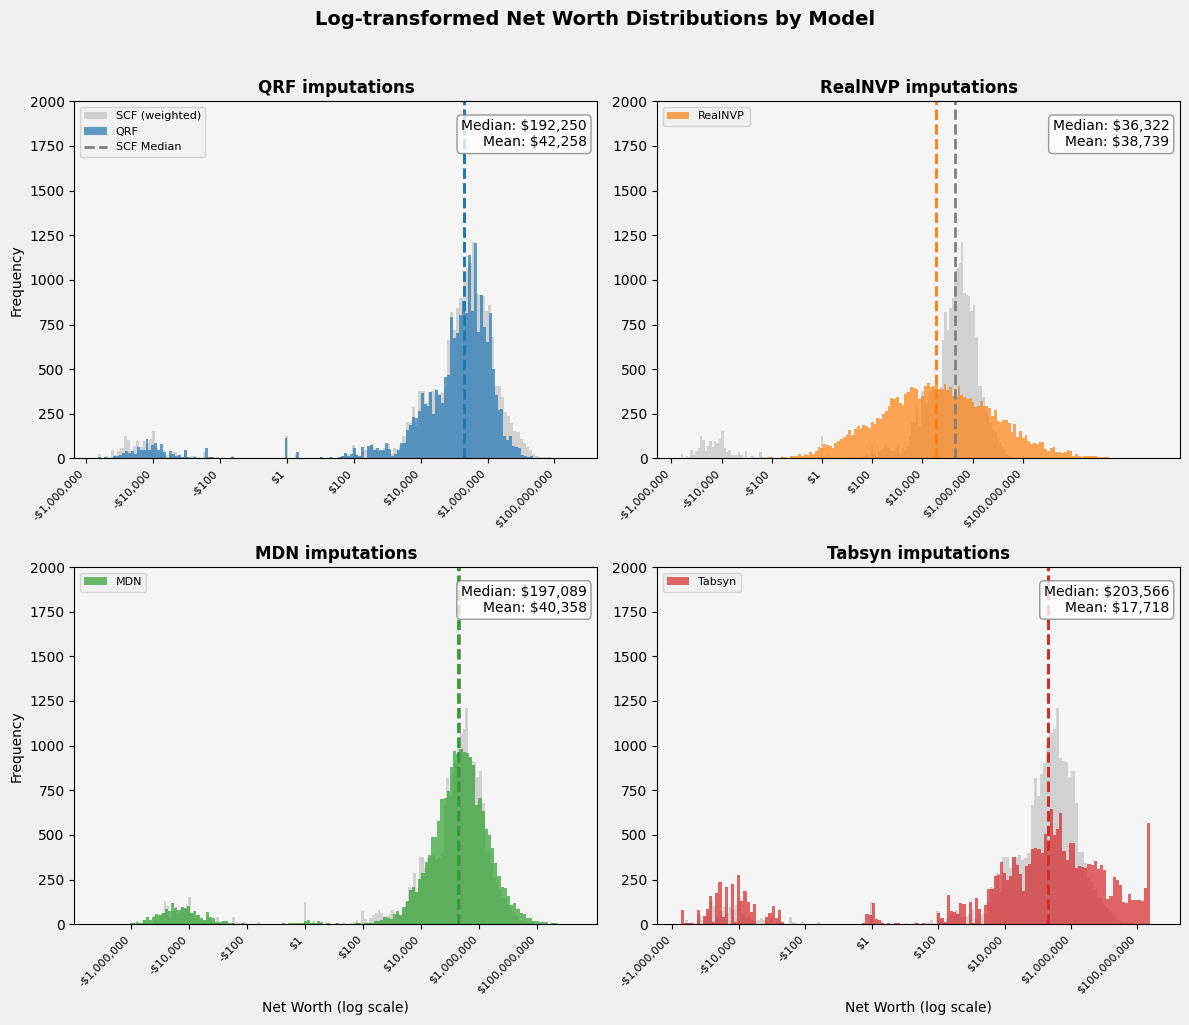

In [ ]:
# Create dictionary of model results
model_results = {
    "QRF imputations": pd.Series(qrf_net_worth_imputed),
    "RealNVP imputations": pd.Series(realnvp_net_worth_imputed.flatten()),
    "MDN imputations": pd.Series(mdn_net_worth_sampled),
    "Tabsyn imputations": pd.Series(tabsyn_networth),
}

# Create and show the combined plot
combined_fig = plot_all_models_log_distributions(
    scf_data["networth"], model_results,
    donor_weights=scf_weights, receiver_weights=cps_weights,
)
combined_fig.show()

<!-- TODO: Add discussion covering:
- Interpretation of results
- Comparison with QRF baseline
- Strengths and weaknesses of each method
- Computational considerations
- Implications for policy analysis
-->

#### AI Statement:

I used Claude Code from my IDE primarily to develop the code adaptation of TabSyn for full variable imputation, as well as to summarize and reorganize certain report sections for conciseness. 